# A common workflow: raw data to plot

The somewhat well established method of analising data is a two step approach, consisting of data acquisition and visualisation. The *acquisition* is usually done with `cdo` ([Climate Data Operator](https://code.mpimet.mpg.de/projects/cdo/embedded/cdo.pdf)) and is meant to select a subset of the data that is small enough to be handled. This can be:
 
 * cutting out areas of interest
 * discarding unused variables
 * selecting time frames
 * averaging over time intervals
 * interpolate to another grid
 
`cdo` usually takes an input file and gives out an output file (usually smaller). `cdo` is fast. And `cdo` has a python interface. For many operations it is nevertheless advisable to submit them to the slurm queue system in order to take advantage of the real computing power of the DKRZ. Simple operations can be done directly in the terminal or a notebook.

In [1]:
import os
path = '/work/mh0010/m300408/DVC-test/EUREC4A-ICON/EUREC4A/experiments/EUREC4A'  # on levante.dkrz.de
path = '/Users/admin/eureca/'
ifile = path + 'EUREC4A_DOM01_radiation_test.nc'
ofile = path + 'cdo_output.nc'
os.listdir(path)

['EUREC4A_DOM02_radiation_test.nc',
 'EUREC4A_PR1250m_DOM01.nc',
 'EUREC4A_DOM01_radiation_test.nc',
 'cdo_output.nc']

In [2]:
# operations on the data
selvar  = 'select,name=thb_t,sob_t' # discard all but two variables
timeavg = 'timselavg,6'             # average over the 6 available time steps (omitted here)
command = 'time cdo '+selvar+' '+ifile+' '+ofile
print(command)
exit_code = os.system(command) # use cdo in the terminal and measure the time

time cdo select,name=thb_t,sob_t /Users/admin/eureca/EUREC4A_DOM01_radiation_test.nc /Users/admin/eureca/cdo_output.nc


cdo    select: Processed 9057120 values from 2 variables over 1 timestep [0.05s 104MB].

real	0m0.115s
user	0m0.035s
sys	0m0.035s


Because the input data is small the operation is fast. For larger jobs it is advisable to submit a script to the slurm queue. A bash script would be the natural choice, but The same thing can be achieved with python. Here an example of a bash script meant to derive monthly means from a global storm resolving simulation:

```bash
#!/bin/bash
#SBATCH --partition=compute
#SBATCH --account=mh0926
#SBATCH --nodes=1
#SBATCH --ntasks-per-node=24
#SBATCH --time=02:00:00
#SBATCH --mail-type=ALL
#SBATCH --mail-user=hernan.campos@mpimet.mpg.de
#SBATCH --output=log/%x.%j.log
#SBATCH --error=log/%x.%j.log

# this is intended to get monthly means of 2D DYAMOND radiation data 
# for comparison with CERES EBAF satelite data

# selection
vars='rlut,rsdt,rsut'
monthlist=('01' '02' '03')

# dpp0052
dirname='/work/mh0287/k203123/GIT/icon-aes-dyw3/experiments/dpp0052/'
namemask='dpp0052_atm_2d_ml_2020'
outmask="dpp0052_radiation_2020"

# dpp0016
dirname='/work/mh0287/k203123/GIT/icon-aes-dyw_albW/experiments/dpp0016/'
namemask='dpp0016_atm_2d_ml_2020'
outmask="dpp0016_radiation_2020"

for month in ${monthlist[@]}; do
    outfile="${outmask}${month}.nc"
    echo "Month ${month}"
    echo ${outfile}

    cdo -P 8 -monmean -cat [ -apply,"-daymean -selname,${vars}" [ "${dirname}${namemask}${month}*" ] ] ${outfile}

    # dry testing
    #echo "${dirname}${namemask}${month}*" 
    #ls ${dirname}${namemask}${month}*
    echo ""
done
```

`cdo` has a python interface that can be used the same way as its commandline counterpart and listens to the same options. Data can be written into files of directly loaded into python as a xarray Dataset.

In [3]:
# import the cdo python interface
from cdo import *
cdo = Cdo()

In [4]:
# write to file
output = cdo.seltimestep('1', input =  ifile, output =  ofile)
output

'/Users/admin/eureca/cdo_output.nc'

In [5]:
# write to temporary file
output = cdo.seltimestep('1', input =  ifile)#, output =  ofile)
output

'/var/folders/0k/t6dd90sx62z4gfqnklc1kkpw0000gp/T/cdoPye9ikqagi'

In [6]:
import xarray as xr
# load to xarray
output = cdo.seltimestep('1', input =  ifile, options = '-r', returnXDataset = True)
output

<xarray.Dataset>
Dimensions:    (time: 1, bnds: 2, ncells: 4528560)
Coordinates:
  * time       (time) datetime64[ns] 2020-02-11T20:00:00
Dimensions without coordinates: bnds, ncells
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    sob_t      (time, ncells) float32 ...
    thb_t      (time, ncells) float32 ...
Attributes:
    CDI:                  Climate Data Interface version 1.9.10 (https://mpim...
    Conventions:          CF-1.6
    number_of_grid_used:  99
    uuidOfHGrid:          6b59890b-99f3-939b-e76a-0a3ad2e43140
    source:               icon\tgit@gitlab.dkrz.de:icon/icon.git@4069b6a8604a...
    institution:          Max Planck Institute for Meteorology
    title:                ICON simulation
    history:              Tue Apr 19 20:43:41 2022: cdo -O -f nc -r -seltimes...
    references:           see MPIM/DWD publications
    comment:              Hauke Schulz (m300408) on l40643 (Linux 4.18.0-305....
    CDO:                  Climate Data Operators version 1.9.10 (https://mpim...

The data we have is *unstructured*. This describes, that there is no spatial information linked to the dataset ([It is not lacking structure...](https://easy.gems.dkrz.de/Processing/playing_with_triangles/grid_index_ordering.html)). If we want to make e.g. a map like plot, we need spatial information. This information is stored seperately in a grid file. Grid files are also in netCDF format and can be loaded and manipulated in the same way as the model output.
We can use `cdo`s merge option to combine the model output with the grid information. For convenience lot of redundant information about the grid is stored in this file. 

In [7]:
grid = path+'EUREC4A_PR1250m_DOM01.nc'
output = cdo.merge( input = grid+' '+ifile, options = '-r', returnXDataset = True)
output

<xarray.Dataset>
Dimensions:                        (time: 1, bnds: 2, vertex: 2267417, ne: 6, cell: 4528560, nv: 3, edge: 6795976, no: 4, nc: 2, max_chdom: 1, cell_grf: 14, edge_grf: 24, vert_grf: 13, ncells: 4528560)
Coordinates:
  * time                           (time) datetime64[ns] 2020-02-11T20:00:00
    vlon                           (vertex) float64 ...
    vlat                           (vertex) float64 ...
    clon                           (cell) float64 ...
    clat                           (cell) float64 ...
    elon                           (edge) float64 ...
    elat                           (edge) float64 ...
Dimensions without coordinates: bnds, vertex, ne, cell, nv, edge, no, nc, max_chdom, cell_grf, edge_grf, vert_grf, ncells
Data variables: (12/54)
    time_bnds                      (time, bnds) datetime64[ns] ...
    vlon_bnds                      (vertex, ne) float64 ...
    vlat_bnds                      (vertex, ne) float64 ...
    clon_bnds                      (cell, nv) float64 ...
    clat_bnds                      (cell, nv) float64 ...
    elon_bnds                      (edge, no) float64 ...
    ...                             ...
    start_idx_v                    (max_chdom, vert_grf) int32 ...
    end_idx_v                      (max_chdom, vert_grf) int32 ...
    parent_edge_index              (edge) int32 ...
    parent_vertex_index            (vertex) int32 ...
    sob_t                          (time, ncells) float32 ...
    thb_t                          (time, ncells) float32 ...
Attributes: (12/20)
    CDI:                  Climate Data Interface version 1.9.10 (https://mpim...
    Conventions:          CF-1.6
    number_of_grid_used:  99
    uuidOfHGrid:          6b59890b-99f3-939b-e76a-0a3ad2e43140
    institution:          Max Planck Institute for Meteorology
    title:                ICON grid description
    ...                   ...
    grid_level:           12
    grid_root:            2
    uuidOfParHGrid:       39f9d5e2-322c-11e6-beee-d15f30d0a215
    global_grid:          0
    history:              Tue Apr 19 20:43:41 2022: cdo -O -f nc -r -merge /U...
    CDO:                  Climate Data Operators version 1.9.10 (https://mpim...

In [8]:
output.thb_t.values

array([[9.96921e+36, 9.96921e+36, 9.96921e+36, ..., 9.96921e+36,
        9.96921e+36, 9.96921e+36]], dtype=float32)

data range:  9.96921e+36  to  9.96921e+36


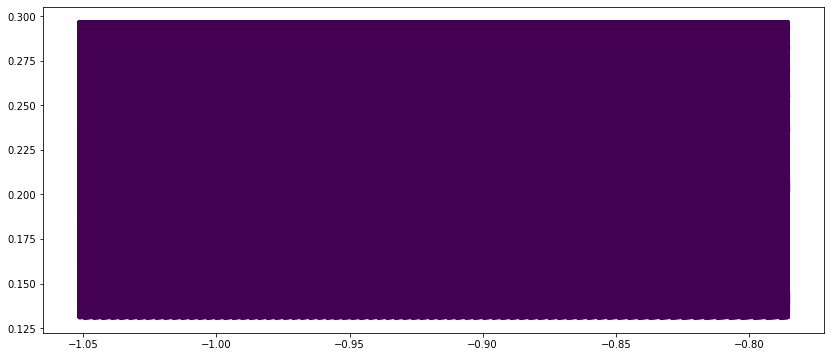

In [10]:
import matplotlib.pyplot as plt

var = 'sob_t'
var = 'thb_t'

fig, ax = plt.subplots(figsize=(14, 6))

x = output.clon
y = output.clat
z = output[var].values

ax.scatter(x, y, c=z, s=4)

print('data range: ', z.min(), ' to ', z.max())

plt.show()

Oops. I guess I should have selected better data... ¯\_(ツ)_/¯

`cdo` is fast, but `xarray` is easy. The syntax is somewhat similar, and for most applications `xarray` will do the trick: 

data range:  9.96921e+36  to  9.96921e+36


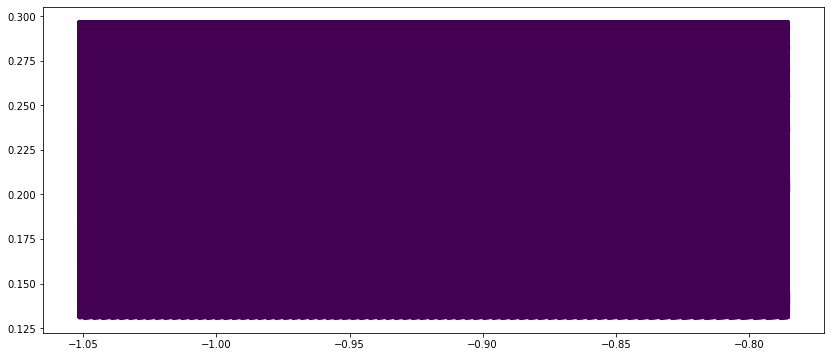

In [11]:
# open with xarray and merge with grid info
g = xr.open_dataset(grid)
d = xr.open_dataset(ifile).merge(g)

# discard variables
yes_list = ['sob_t', 'thb_t', 'time', 'clat', 'clon']
no_list  = [name for name in list(d.variables) if name not in yes_list]
d = d.drop(labels=no_list)

# plot
var = 'sob_t'
var = 'thb_t'

fig, ax = plt.subplots(figsize=(14, 6))

x = d.clon
y = d.clat
z = d[var].values

ax.scatter(x, y, c=z, s=4)

print('data range: ', z.min(), ' to ', z.max())

plt.show()

# The lazy approach

The above workflow does 
 1. break down the data into a subsets and stores them
 2. use these subsets for plotting
 
With the tendency to high resolution models and high resolution outputs, storage becomes a problem. Every user having their own slightly smaller copy of the original dataset takes a lot of disk space. This is not ideal. A different approach is to lazy load the data. You do your calculations and plot afterwards. Your lazy *worker*, will avoid doing any real operations until absolutely necessary. You can load you data, define operations, but real calculations will only be done.
A few notable python libraries for dealing with large data sets are:

 * Instead of folder structures more and more data sets are offered with a `intake` catalog, that allows easy access to large datasets or ensembles.
 * `dask` allows to offload calculations on a cluster by offering distributed data structures. 
 * `datashader` is an efficient rasterisation library, made for the plotting of large datasets.

In [3]:
from intake import open_catalog
import dask

cat_address = "https://raw.githubusercontent.com/observingClouds/eurec4a-intake/simulations/catalog.yml"
cat = open_catalog(cat_address)

rad_raw = cat.simulations.ICON.experiment_1.radiation_DOM01.to_dask()
rad_delete = ['ddt_temp_radlw', 'ddt_temp_radsw', 'height_bnds', 'sod_t', 'sou_t']

with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    rad = rad_raw.drop(labels=rad_delete)

In [4]:
rad

<xarray.Dataset>
Dimensions:  (time: 3004, cell: 4528560)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-09T10:00:00 ... 2020-01-30T10:50:00
Dimensions without coordinates: cell
Data variables:
    sob_t    (time, cell) float32 dask.array<chunksize=(4, 262144), meta=np.ndarray>
    thb_t    (time, cell) float32 dask.array<chunksize=(4, 262144), meta=np.ndarray>
Attributes:
    CDI:                  Climate Data Interface version 1.8.3rc (http://mpim...
    Conventions:          CF-1.6
    comment:              Hauke Schulz (m300408) on m21732 (Linux 2.6.32-754....
    history:              /mnt/lustre02/work/mh0010/m300408/Simulations/ICON/...
    institution:          Max Planck Institute for Meteorology/Deutscher Wett...
    number_of_grid_used:  99
    references:           see MPIM/DWD publications
    source:               git@gitlab.dkrz.de:icon/icon-aes.git@ba5ebcf0ebc106...
    title:                ICON simulation
    uuidOfHGrid:          6b59890b-99f3-939b-e76a-0a3ad2e43140
    uuidOfVGrid:          66f36183-514c-7eb1-a807-11ae4a612be0

`datashader` internally works with pandas data frames (pandas data frames are similar to data structures as in `R` or `SQL`). For a dataset to be plottable with datashader it has to be convertible to a pandas data frame, a step that is done internally when `datashader` is used.

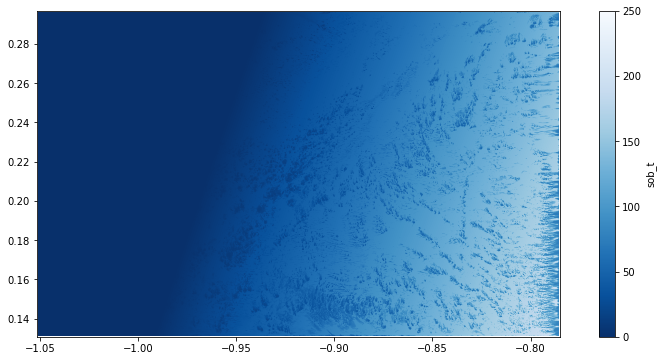

In [5]:
import datashader as ds
from datashader.mpl_ext import dsshow
import matplotlib.pyplot as plt

data = rad.isel(time = -5)
grid = cat.simulations.grids['EUREC4A_PR1250m_DOM01'].to_dask()
dwg  = data.merge(grid)

var = 'sob_t'

fig, ax = plt.subplots(figsize=(14, 6))

artist = ds.mpl_ext.dsshow(
    dwg[["clon", "clat", var]].load(),
    ds.Point("clon", "clat"),
    aggregator=ds.mean(var),
    cmap=plt.get_cmap('Blues').reversed(), 
    vmin=0,
    vmax=250,
    ax=ax,
)
fig.colorbar(artist, label=var)
plt.show()

## There are many resources out there. 
Ask you peers, ask your working groups, google stuff... you know the drill. 


## A few resources:
 * [Dealing with unstructured data](https://easy.gems.dkrz.de/Processing/playing_with_triangles/index.html)
 * [Access data from the EUREC4A campaign](https://howto.eurec4a.eu/bacardi.html)
 * Many people have a github account with valuable resources. And you should, too. Set one up! 

/var/folders/0k/t6dd90sx62z4gfqnklc1kkpw0000gp/T/ipykernel_13584/3737708898.py:4: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``np.array(PIL.Image.open(urllib.request.urlopen(url)))``.
  image = mpimg.imread(path)


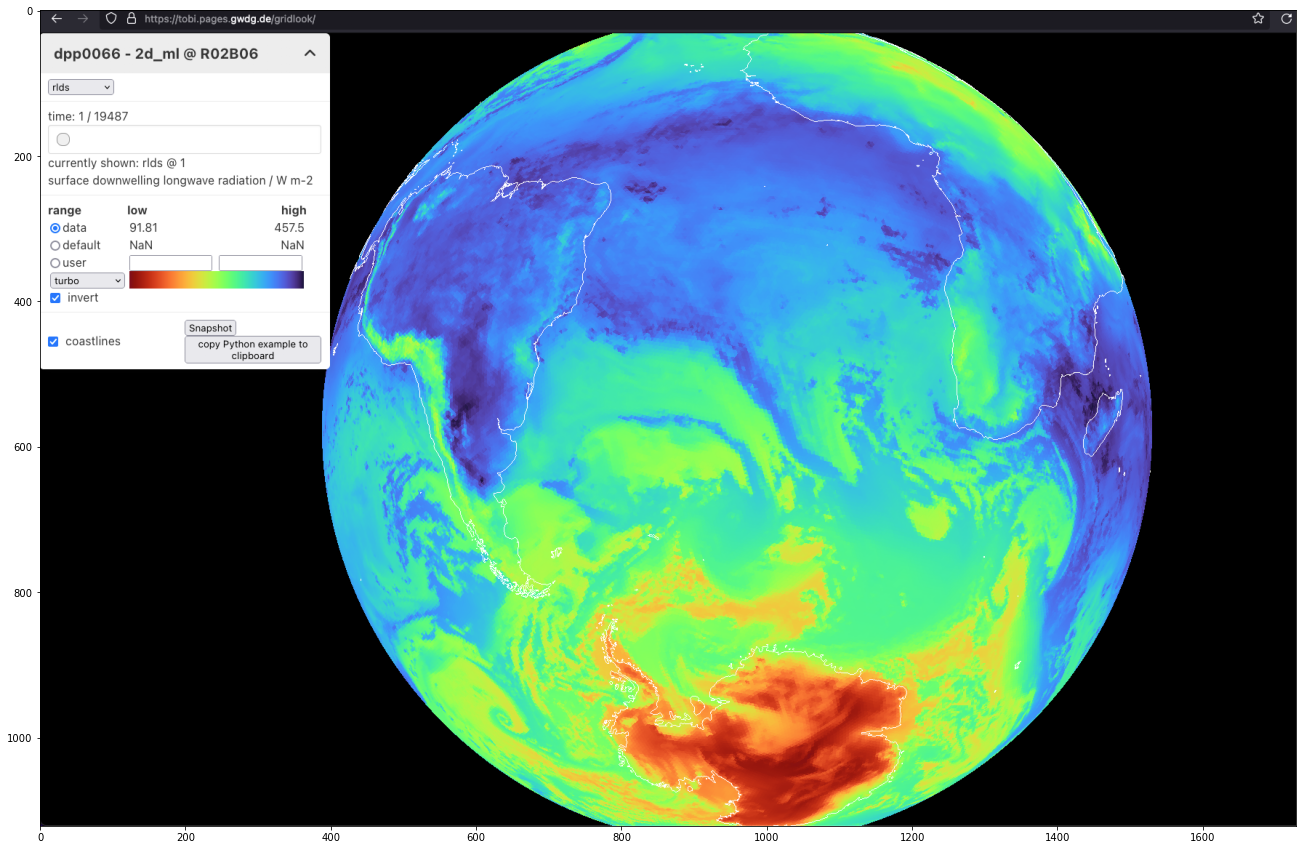

In [6]:
from matplotlib import image as mpimg

def display_image(path):
    image = mpimg.imread(path)
    fig, ax = plt.subplots(figsize=(30, 15))
    ax.imshow(image)

display_image('https://i.imgur.com/PjxZWGT.png')

This Tool is under [active development](https://gitlab.gwdg.de/tobi/gridlook/-/issues) (by Tobias Kölling). New features are on the way, e.g. the possibility to load custom data into the tool.
To  the `copy Python example to clipboard` button code can be exported and used in a notebook. The following example is the plot of the image above:

code generated from https://tobi.pages.gwdg.de/gridlook/


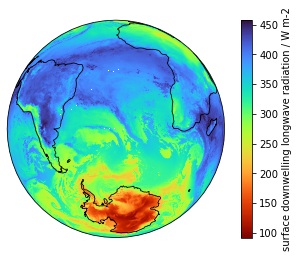

In [1]:
gridlook = 'https://tobi.pages.gwdg.de/gridlook/'
print('code generated from ' + gridlook)

import xarray as xr
import numpy as np
import pandas as pd

import matplotlib.pylab as plt
import datashader
from datashader.mpl_ext import dsshow

import cartopy.crs as ccrs
import cartopy.feature as cf


data = xr.open_zarr("https://swift.dkrz.de/v1/dkrz_948e7d4bbfbb445fbff5315fc433e36a/dpp0066/R02B06/2d_ml.zarr")
grid = xr.open_zarr("https://swift.dkrz.de/v1/dkrz_948e7d4bbfbb445fbff5315fc433e36a/nextGEMS/grids/ICON_R02B06.zarr")

central_longitude = -18.000000000000032
central_latitude = -41.59999999999995
satellite_height = 86605295.46145515

vmin = 91.81074523925781
vmax = 457.4525146484375
cmap = "turbo_r"

variable = data["rlds"].isel(time=1)

projection = ccrs.NearsidePerspective(central_longitude=central_longitude, central_latitude=central_latitude, satellite_height=satellite_height)

coords = projection.transform_points(
    ccrs.Geodetic(),
    np.rad2deg(grid.clon),
    np.rad2deg(grid.clat),
)

fig, ax = plt.subplots(subplot_kw={"projection": projection})
fig.canvas.draw_idle()
ax.add_feature(cf.COASTLINE, linewidth=0.8)

artist = dsshow(
    pd.DataFrame({
        "val": variable.values,
        "x": coords[:, 0],
        "y": coords[:, 1],
    }),
    datashader.Point('x', 'y'),
    datashader.mean('val'),
    vmin=vmin,
    vmax=vmax,
    cmap=cmap,
    ax=ax,
)

fig.colorbar(artist, label=f"{variable.long_name} / {variable.units}")
